In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import os
import cv2
import random
import ntpath

%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', None)

## LOAD DATA

In [3]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv('driving_log.csv', index_col = None, names = columns)
data.head()

center  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\center_2021_06_03_22_58_41_984.jpg   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\center_2021_06_03_22_58_42_052.jpg   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\center_2021_06_03_22_58_42_119.jpg   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\center_2021_06_03_22_58_42_186.jpg   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\center_2021_06_03_22_58_42_254.jpg   

                                                                                                                                                                                                         left  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\left_2021_06_03_22_58_41_984.jpg   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\left_2021_06_03_22_58_42_052.jpg   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\left_2021_06_03_22_58_42_119.jpg   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\left_2021_06_03_22_58_42_186.jpg   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\left_2021_06_03_22_58_42_254.jpg   

                                                                                                                                                                                                         right  \
0  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\right_2021_06_03_22_58_41_984.jpg   
1  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\right_2021_06_03_22_58_42_052.jpg   
2  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\right_2021_06_03_22_58_42_119.jpg   
3  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\right_2021_06_03_22_58_42_186.jpg   
4  C:\Users\Soundarya.Rupavatara\OneDrive - Clyde Industries Inc\Desktop\Springboard\SpringBoardDS-J21\30_Capstone03\SELF_DRIVING_UDASIM\beta_simulator_windows\usimData\IMG\right_2021_06_03_22_58_42_254.jpg   

   steering  throttle  reverse     speed  
0       0.0       0.0        0  0.000012  
1       0.0       0.0        0  0.000013  
2       0.0       0.0        0  0.000011  
3       0.0       0.0        0  0.000003  
4       0.0       0.0        0  0.000002

In [4]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


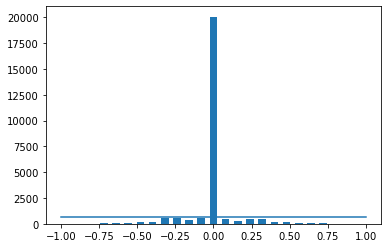

In [5]:
center = (bins[:-1] + bins[1:]) * 0.5 

threshold = 700  # To avoid steering bias

plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (threshold, threshold))

## PREPROCESSING DATA

### BALANCE STEERING DATA

In [6]:
print('TOTAL DATA', len(data))
biased_data = []

for j in range(num_bins):
    lst = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            lst.append(i)
    lst = shuffle(lst)
    lst = lst[threshold:]
    biased_data.extend(lst)
print('BIASED DATA', len(biased_data))

TOTAL DATA 24912
BIASED DATA 19367


In [7]:
data.drop(data.index[biased_data], inplace = True)
print('BALANCED DATA', len(data))

BALANCED DATA 5545


In [8]:
hist, _ = np.histogram(data['steering'], num_bins)

Text(0.5, 0, 'steering')

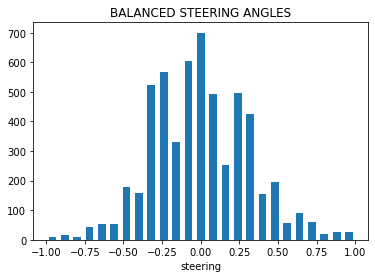

In [9]:
plt.bar(center, hist, width = 0.05)
plt.title('BALANCED STEERING ANGLES')
plt.xlabel('steering')

## TRAIN TEST SPLIT 
### IMAGE/STEERING DATA

In [10]:
def load_img_steering(df):
    image_path = []
    steering = []
    for i in range(len(data)):
        
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        
        # center image append
        image_path.append(center)
        steering.append(float(indexed_data[3]))
        
        # left image append
        image_path.append(left)
        steering.append(float(indexed_data[3])+0.15)
        
        # right image append
        image_path.append(right)
        steering.append(float(indexed_data[3])-0.15)
        
        image_paths = np.asarray(image_path)
        steerings = np.asarray(steering)
        
    return image_paths, steerings
 
img_paths, steerings = load_img_steering(data)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(img_paths, steerings, test_size=0.2, random_state=6, shuffle = True)

In [12]:
print('Training Samples', len(X_train))
print('Validation Samples', len(X_val))

Training Samples 13308
Validation Samples 3327


Text(0.5, 1.0, 'Validation Set')

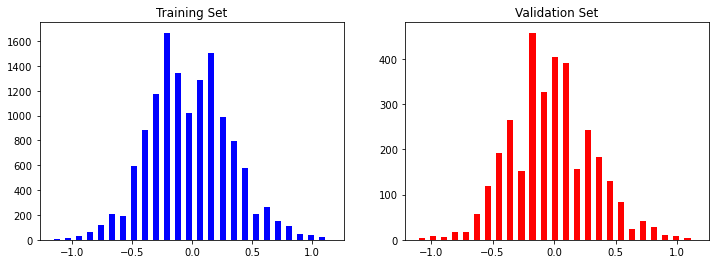

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].hist(y_train, num_bins, width = 0.05, color = 'blue')
ax[0].set_title('Training Set')
ax[1].hist(y_val, num_bins, width = 0.05, color = 'red')
ax[1].set_title('Validation Set')

### IMAGE PREPROCESSING

### IMAGE DATA GENERATOR - DATA AUGMENTATION

#### ZOOM

In [14]:
def zoom(img):
    zoom = iaa.Affine(scale = (1, 1.3))
    img = zoom.augment_image(img)
    return img

Text(0.5, 1.0, 'Zoomed Image')

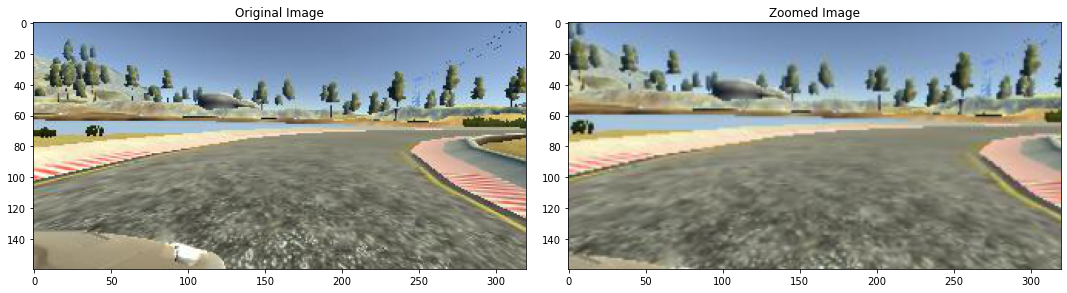

In [15]:
im_path = img_paths[random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

zoomed_img = zoom(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(zoomed_img)
ax[1].set_title('Zoomed Image')

#### PAN

In [16]:
def pan(img):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    img = pan.augment_image(img)
    return img

Text(0.5, 1.0, 'Panned Image')

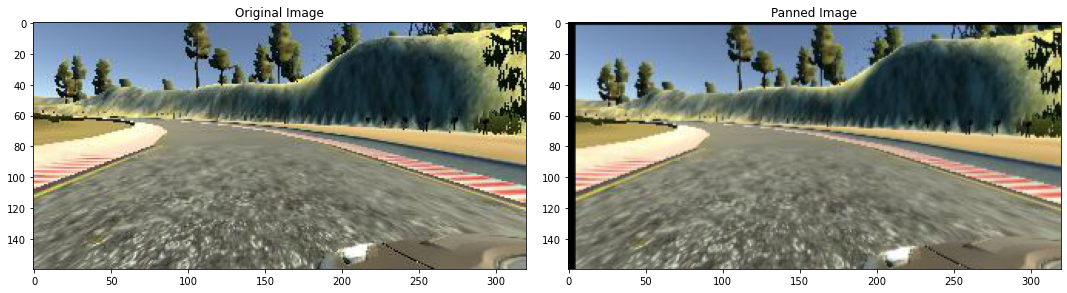

In [17]:
im_path = img_paths[random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pan_img = pan(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(pan_img)
ax[1].set_title('Panned Image')

#### BRIGHTNESS

In [18]:
def img_random_brightness(img):
    brightness = iaa.Multiply((0.2, 1.2))
    img = brightness.augment_image(img)
    return img

Text(0.5, 1.0, 'Random Brightness Image')

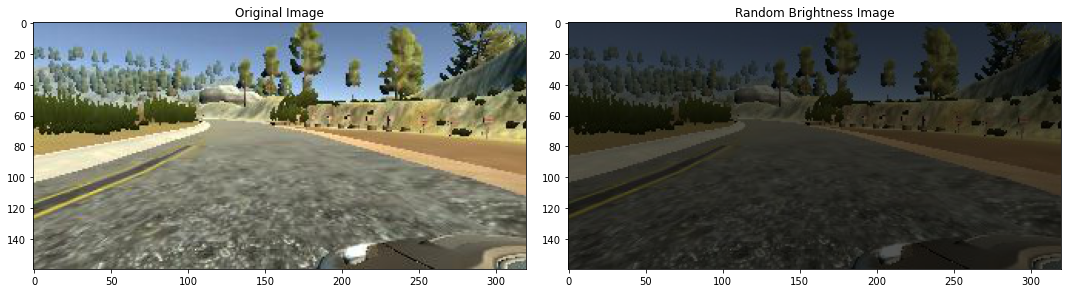

In [19]:
im_path = img_paths[random.randint(0, 1000)]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

rb_img = img_random_brightness(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(rb_img)
ax[1].set_title('Random Brightness Image')

#### FLIP

In [20]:
def img_random_flip(img, steering_angle):
    img = cv2.flip(img,1)
    steering_angle = -steering_angle
    return img, steering_angle

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.4')

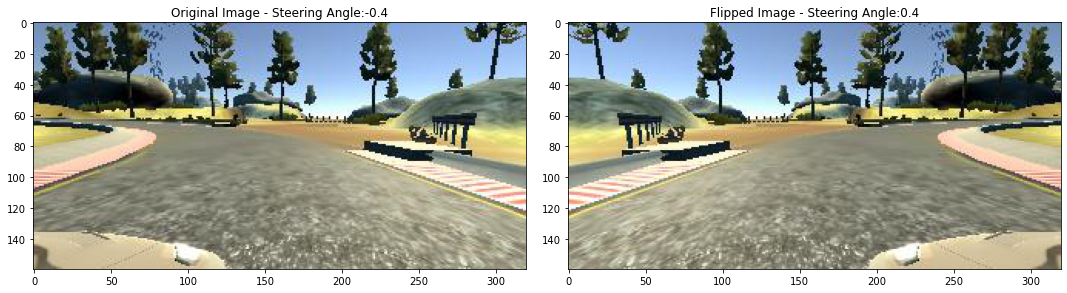

In [21]:
rand_index  = random.randint(0, 1000)
im_path = img_paths[rand_index]
steering_angle = steerings[rand_index]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

flipped_img, flipped_steering_angle = img_random_flip(original_img, steering_angle)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
ax[1].imshow(flipped_img)
ax[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

#### RANDOM AUGMENTATION

In [22]:
def random_augment(img, steering_angle):
    img = mpimg.imread(img)
    
    if np.random.rand() < 0.5:
        img = pan(img)
    if np.random.rand() < 0.5:
        img = zoom(img)
    if np.random.rand() < 0.5:
        img = img_random_brightness(img)
    if np.random.rand() < 0.5:
        img, steering_angle = img_random_flip(img, steering_angle)
    
    return img, steering_angle

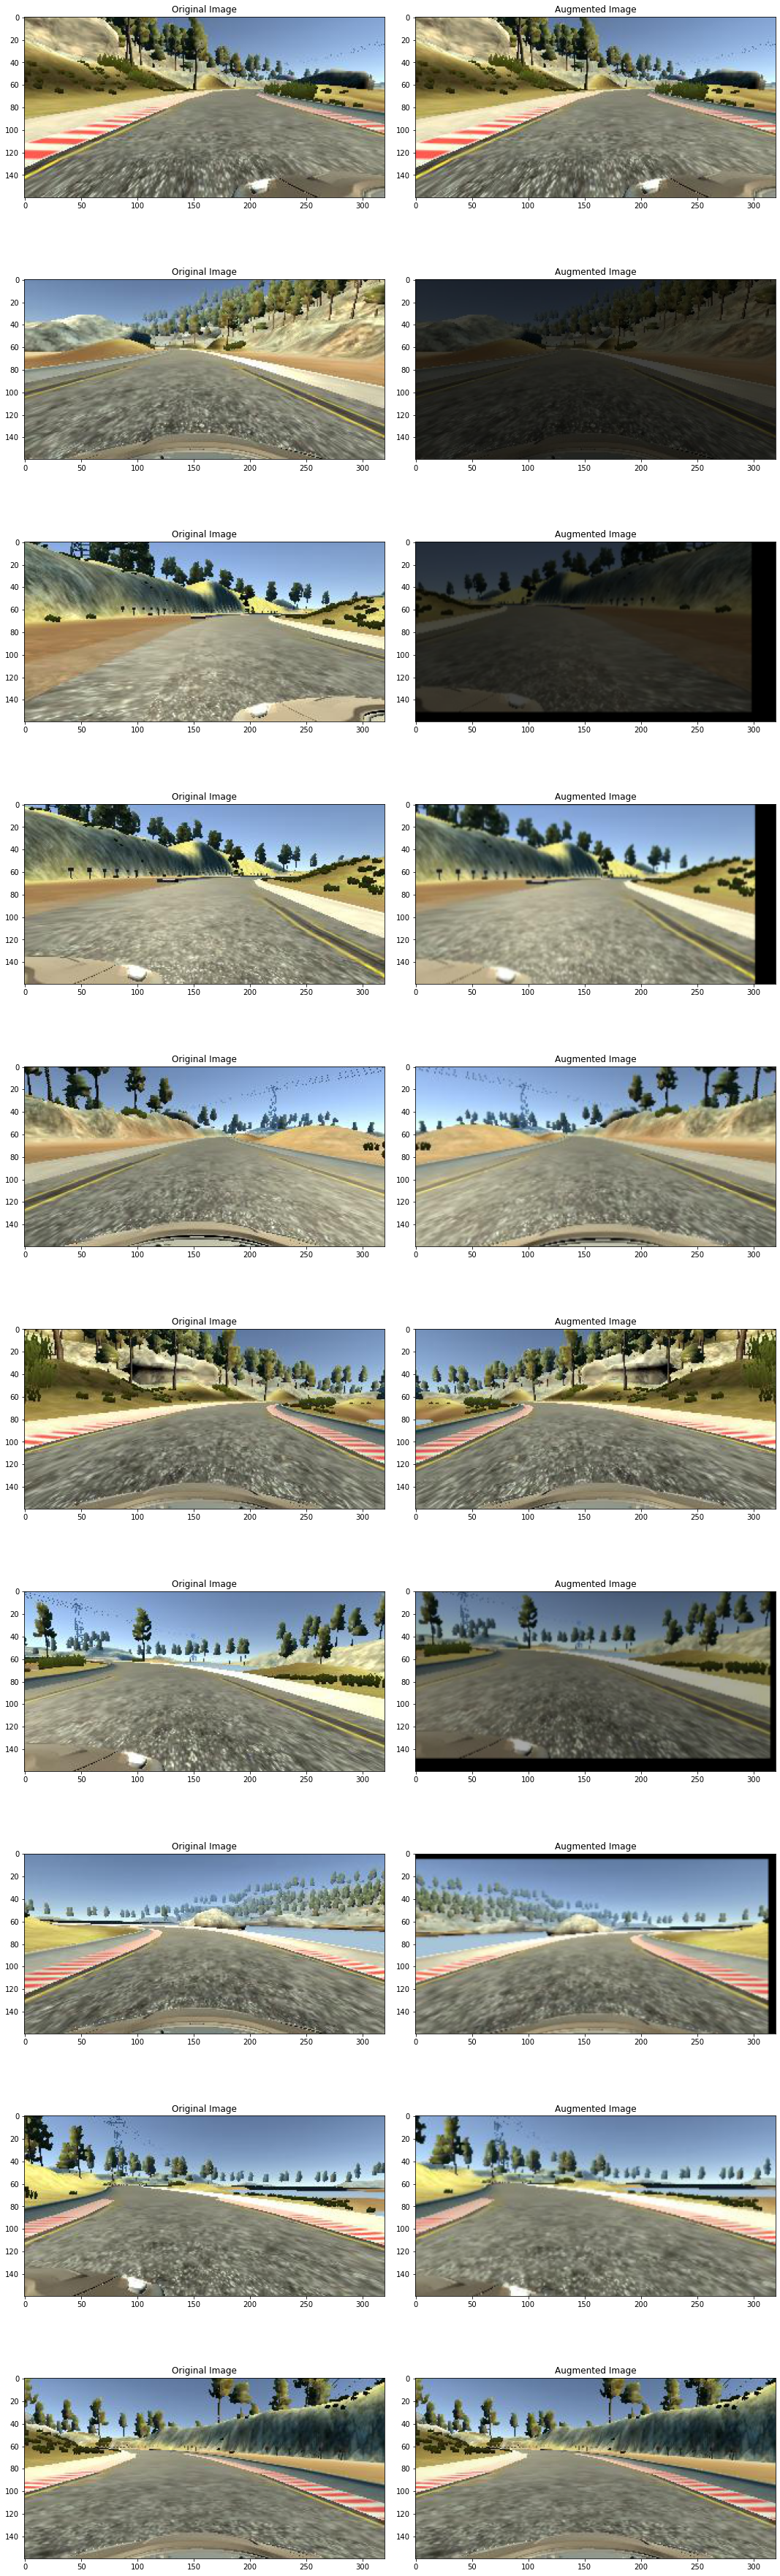

In [23]:
ncol = 2
nrow = 10
 
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
    rand_num = random.randint(0, len(img_paths) - 1)
    random_img = img_paths[rand_num]
    random_steering = steerings[rand_num]
    
    original_img = cv2.imread(random_img)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    augmented_img, steering = random_augment(random_img, random_steering)
    
    ax[i][0].imshow(original_img)
    ax[i][0].set_title("Original Image")
  
    ax[i][1].imshow(augmented_img)
    ax[i][1].set_title("Augmented Image")

In [24]:
def img_preprocessing(img):
    
    # CROP THE HOOD
    img = img[60:135, :, :]
    
    # YUV CONVERSION
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    # NOISE REDUCTION - GAUSSIAN BLUR
    img = cv2.GaussianBlur(img, (3, 3), 0)
    
    # Resize Image
    img = cv2.resize(img, (200, 66))
    
    # Normalization
    img = img/255
    
    return img

Text(0.5, 1.0, 'Processed Image')

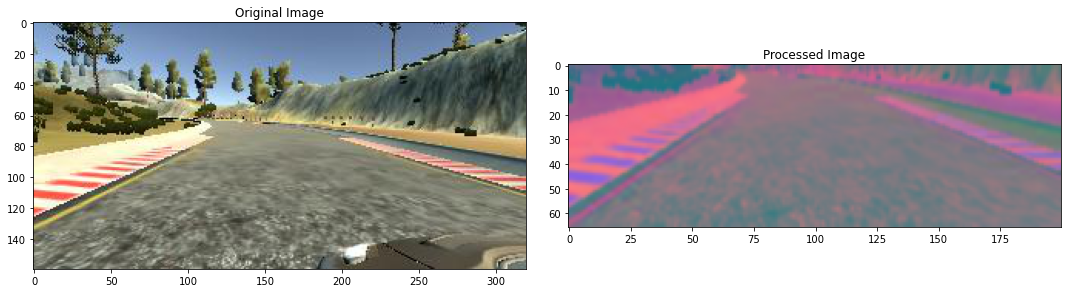

In [25]:
im_path = img_paths[100]

img = cv2.imread(im_path)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

processed_img = img_preprocessing(original_img)   

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_img)
ax[0].set_title('Original Image')
ax[1].imshow(processed_img)
ax[1].set_title('Processed Image')

In [26]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = cv2.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocessing(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

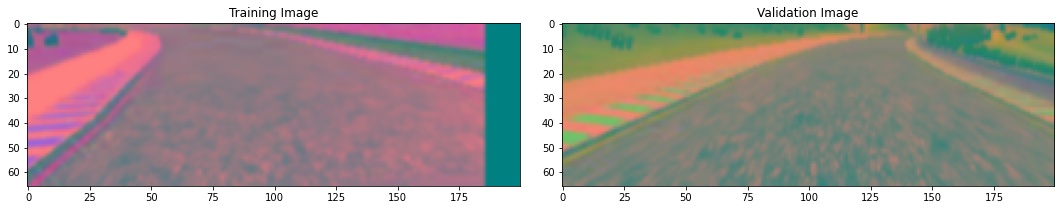

In [27]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_val_gen[0])
axs[1].set_title('Validation Image')

## MODELING

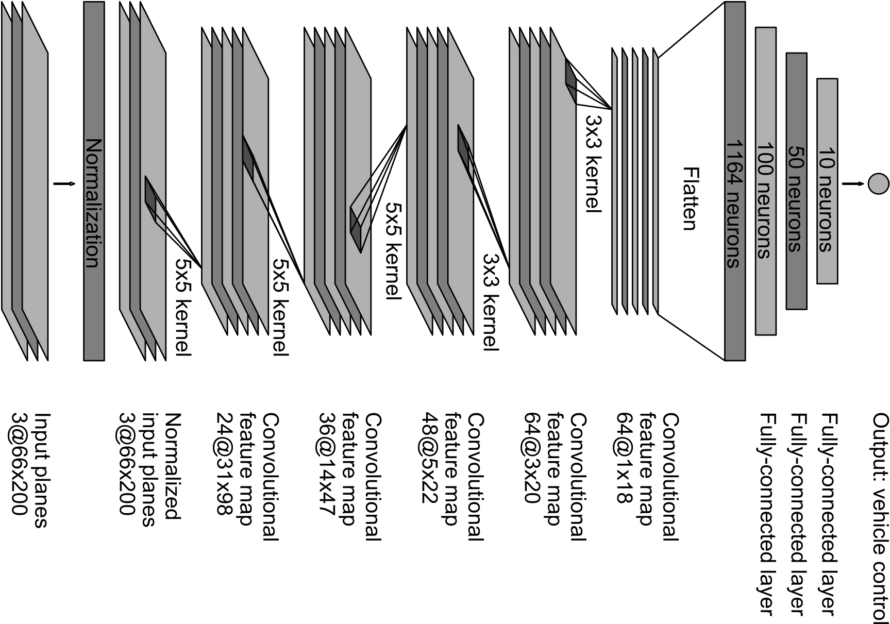

In [28]:
def nvidia_model():
 
    model = Sequential()

    model.add(Conv2D(24, kernel_size = (5,5), strides = (2,2), input_shape = (66,200,3), activation = 'elu'))
    model.add(Conv2D(36, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(48, kernel_size = (5,5), strides = (2,2), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'elu'))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'elu'))
    #model.add(Dropout(0.5))


    model.add(Flatten())
    
    model.add(Dense(100, activation = 'elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(10, activation = 'elu'))
    #model.add(Dropout(0.5))
    
    model.add(Dense(1))


    optimizer= Adam(learning_rate = 1e-3)
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

In [29]:
model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

In [30]:
history = model.fit(batch_generator(X_train, y_train, 100, 1), 
                    steps_per_epoch = 300, 
                    epochs = 10, 
                    validation_data = batch_generator(X_val, y_val, 100, 0), 
                    validation_steps = 200, verbose = 1, shuffle = 1)

Epoch 1/10
300/300 [==============================] - 697s 2s/step - loss: 0.2458 - val_loss: 0.1590
Epoch 2/10
300/300 [==============================] - 511s 2s/step - loss: 0.0723 - val_loss: 0.3528
Epoch 3/10
300/300 [==============================] - 497s 2s/step - loss: 0.0586 - val_loss: 0.2037
Epoch 4/10
300/300 [==============================] - 486s 2s/step - loss: 0.0520 - val_loss: 0.1289
Epoch 5/10
300/300 [==============================] - 487s 2s/step - loss: 0.0502 - val_loss: 0.0993
Epoch 6/10
300/300 [==============================] - 506s 2s/step - loss: 0.0476 - val_loss: 0.0971
Epoch 7/10
300/300 [==============================] - 513s 2s/step - loss: 0.0460 - val_loss: 0.1101
Epoch 8/10
300/300 [==============================] - 499s 2s/step - loss: 0.0455 - val_loss: 0.0882
Epoch 9/10
300/300 [==============================] - 427s 1s/step - loss: 0.0436 - val_loss: 0.0673
Epoch 10/10
300/300 [==============================] - 417s 1s/step - loss: 0.0429 - val_lo

Text(0.5, 0, 'Epoch')

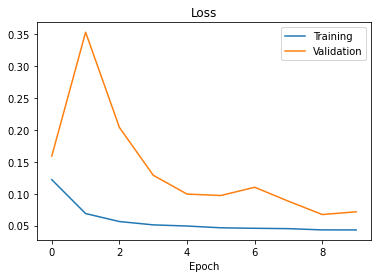

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [32]:
model.save('scd_model.h5')